# showq analysis

## Preprocessing

The output of Adaptive Computing Moab `showq` command has to be preprocessed by `scripts/showq2csv.py`. It will create a CSV file that can be imported by pandas.

## Prerequisites

Import required modules.

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
%matplotlib inline

Ensure that modules are reloaded automatically when modified.

In [24]:
%load_ext autoreload
%autoreload 2

In [25]:
from lib.vsc.moab.nb_utils import extract_state

## Analysis

The time stamp and date-time column should be parsed as data-time information, they are in the default format, so we don't need to use a custom formatter.

In [88]:
job_df = pd.read_csv('data/showq.csv', parse_dates=['time_stamp', 'datetime'])

In [89]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 9 columns):
category      724 non-null object
time_stamp    724 non-null datetime64[ns]
job_id        724 non-null object
user_id       724 non-null object
state         724 non-null object
procs         724 non-null int64
duration      724 non-null int64
datetime      724 non-null datetime64[ns]
derived       724 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 51.0+ KB


In [55]:
job_df.head()

,category,time_stamp,job_id,user_id,state,procs,duration,datetime,derived
0,ActiveJob,2018-06-10 08:13:16.254774,20788108,vsc30675,Running,20,84579,2018-04-11 09:08:57,5.265238e+06
1,ActiveJob,2018-06-10 08:13:16.254774,20786357,vsc31046,Running,24,6428,2018-04-10 10:56:26,5.267038e+06
2,ActiveJob,2018-06-10 08:13:16.254774,20786387,vsc32051,Running,20,8543,2018-04-08 11:31:41,5.439838e+06
3,ActiveJob,2018-06-10 08:13:16.254774,20787980,vsc31935,Running,40,18715,2018-04-10 14:21:13,5.267038e+06
4,ActiveJob,2018-06-10 08:13:16.254774,20785171,vsc32218,Running,20,24000,2018-04-06 15:49:18,5.612638e+06


In [90]:
running_df = extract_state(job_df, 'Running')

In [91]:
running_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 9 columns):
category          226 non-null object
time_stamp        226 non-null datetime64[ns]
job_id            226 non-null object
user_id           226 non-null object
state             226 non-null object
procs             226 non-null int64
remaining         226 non-null int64
start_time        226 non-null datetime64[ns]
walltime_limit    226 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 17.7+ KB


In [92]:
idle_df = extract_state(job_df, 'Idle')

In [93]:
idle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 226 to 667
Data columns (total 9 columns):
category          442 non-null object
time_stamp        442 non-null datetime64[ns]
job_id            442 non-null object
user_id           442 non-null object
state             442 non-null object
procs             442 non-null int64
walltime_limit    442 non-null int64
queue_time        442 non-null datetime64[ns]
time_in_queue     442 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 34.5+ KB


Count the number of jobs per user, and sort descending, and show top-10.

In [62]:
running_df[['user_id', 'job_id']].groupby('user_id').count().sort_values('job_id', ascending=False).head(10)

,job_id
user_id,
vsc31179,33
vsc32233,32
vsc31064,28
vsc31645,15
vsc31849,11
vsc30668,9
vsc31921,7
vsc31046,7
vsc31662,6


Analyze running jobs' remaining time.

In [64]:
running_df.remaining.apply(lambda x: x/3600).describe()

count    226.000000
mean      83.487179
std       99.543065
min        1.785556
25%       21.567222
50%       55.873194
75%       87.384653
max      488.802500
Name: remaining, dtype: float64

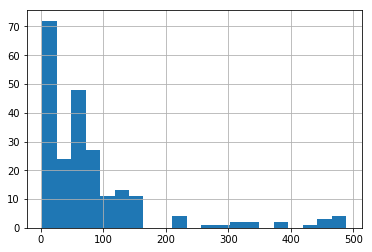

In [70]:
running_df.remaining.apply(lambda x: x/3600).hist(bins=21);

Compute the total work that still needs to be done by running jobs, expressed in core-hours.

In [74]:
(running_df.remaining*running_df.procs).sum(axis=0)/3600

562426.6330555555

Total work for the currently running jobs.

In [79]:
(running_df.walltime_limit*running_df.procs).sum()/3600

10431816.870638292

Number of core currently running jobs.

In [80]:
running_df.procs.sum()

6713

Compute the total work that needs to be done by idle jobs, expressed in core-hours.

In [77]:
(idle_df.walltime_limit*idle_df.procs).sum(axis=0)/3600

501573.5333333333

What is the distribution of the number of processes for the jobs?

In [81]:
running_df.procs.describe()

count    226.000000
mean      29.703540
std       41.710278
min        1.000000
25%       20.000000
50%       20.000000
75%       24.000000
max      336.000000
Name: procs, dtype: float64

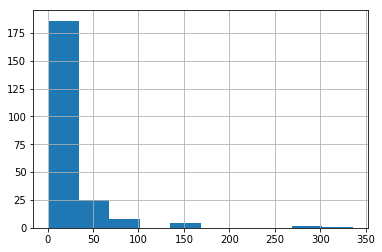

In [82]:
running_df.procs.hist(bins=10);

Who are the users that submit non-trivial jobs?

In [85]:
running_df[['user_id', 'procs']].query('procs > 100').groupby('user_id').count()

,procs
user_id,
vsc30626,4
vsc30637,2
vsc31487,1


What is the distribution of queue times?

In [94]:
idle_df.time_in_queue.describe()/3600

count       0.122778
mean       30.088469
std       104.644086
min         0.191944
25%        22.009722
50%        22.065833
75%        38.055556
max      2152.652778
Name: time_in_queue, dtype: float64

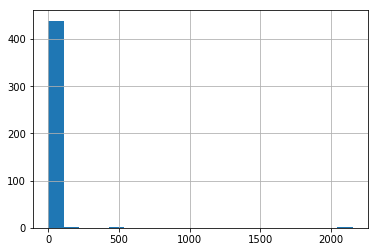

In [96]:
(idle_df.time_in_queue/3600).hist(bins=20)